

Importing the libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

Loading the Dataset



In [4]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
    return df

# Load data
file_path = "C:\\Users\\Intoxicated\\Documents\\data sci\\archive\\WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = load_data(file_path)
df.head()

Dataset loaded with 7043 rows and 21 columns


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


 Basic Data Exploration

In [5]:
# Display basic info
print("\nBasic information about the dataset:")
print(df.info())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
print(df.describe())


Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Pape

 Target Variable Analysis


Churn distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


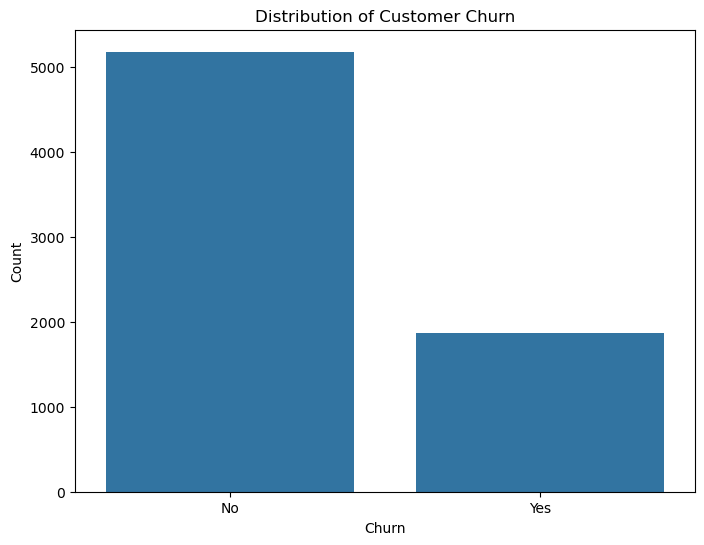

In [6]:
# Check the distribution of the target variable (Churn)
print("\nChurn distribution:")
print(df['Churn'].value_counts())
print(df['Churn'].value_counts(normalize=True) * 100)

# Visualize churn distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Customer Churn')
plt.ylabel('Count')
plt.show()

Feature Analysis - Categorical Variables

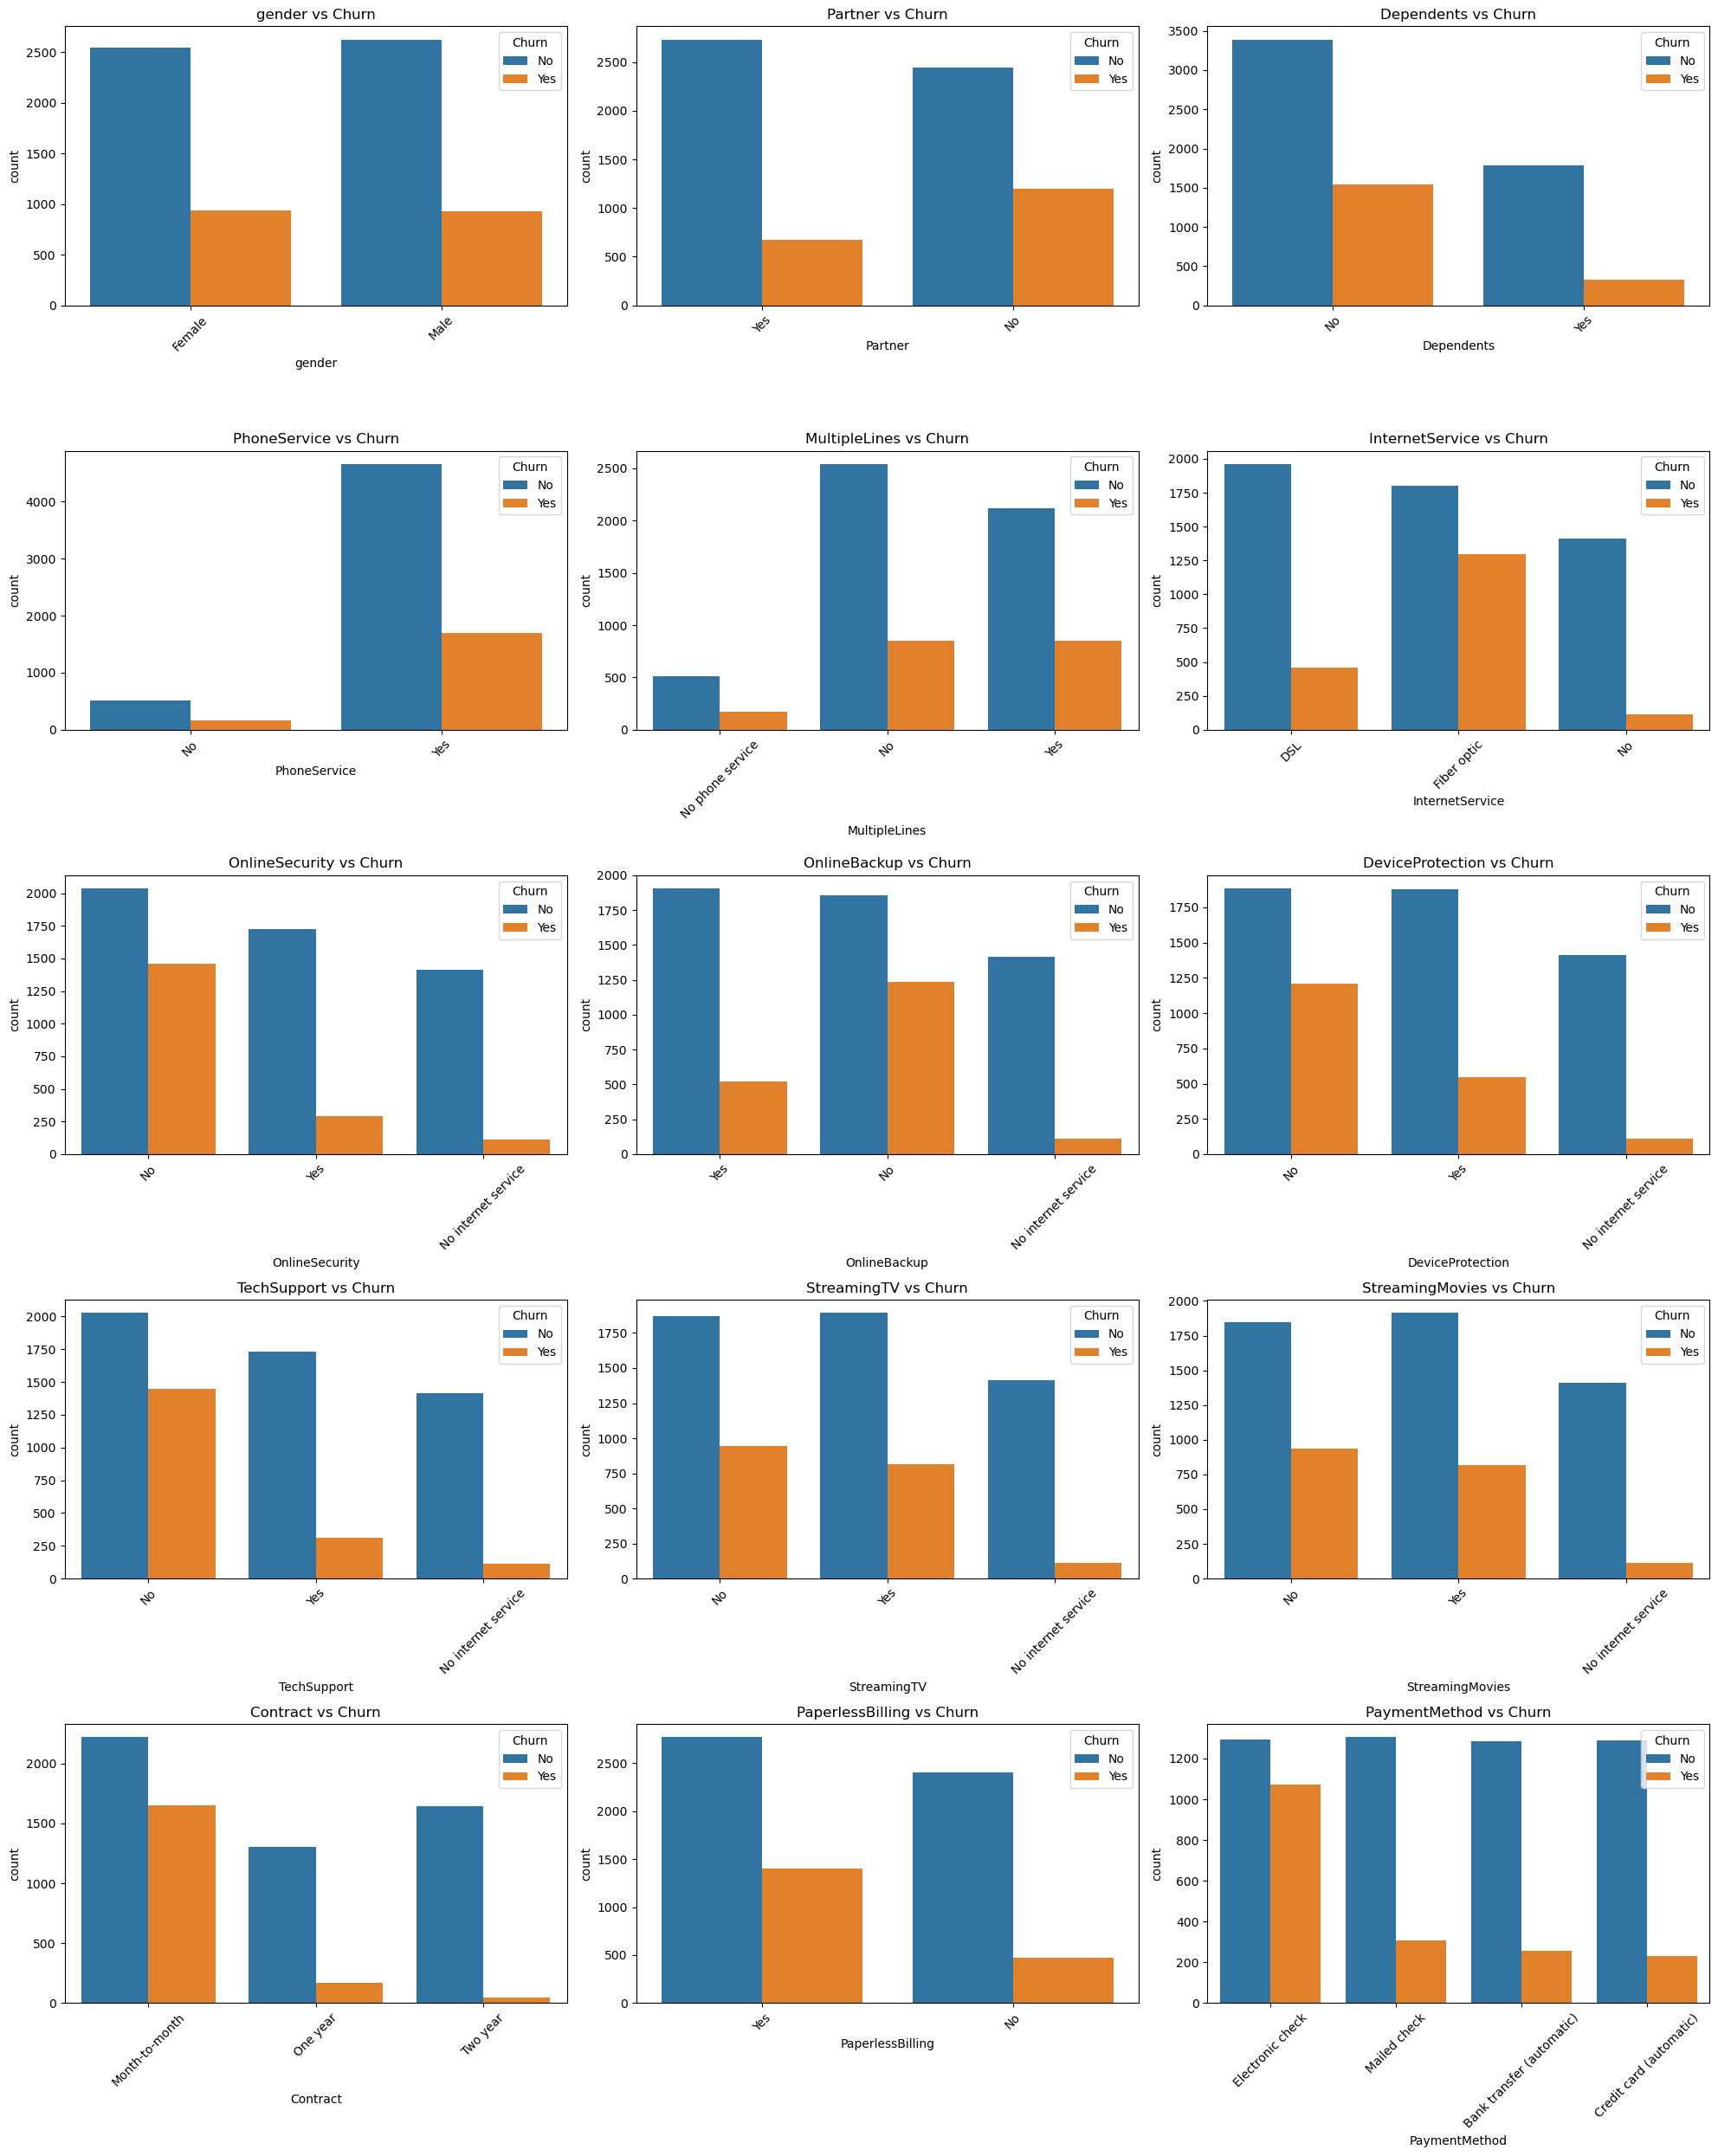

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')
categorical_cols.remove('Churn')

n_cols = 3
n_rows = math.ceil(len(categorical_cols) / n_cols)

plt.figure(figsize=(20, 5 * n_rows))
for i, col in enumerate(categorical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Feature Analysis - Numerical Variables

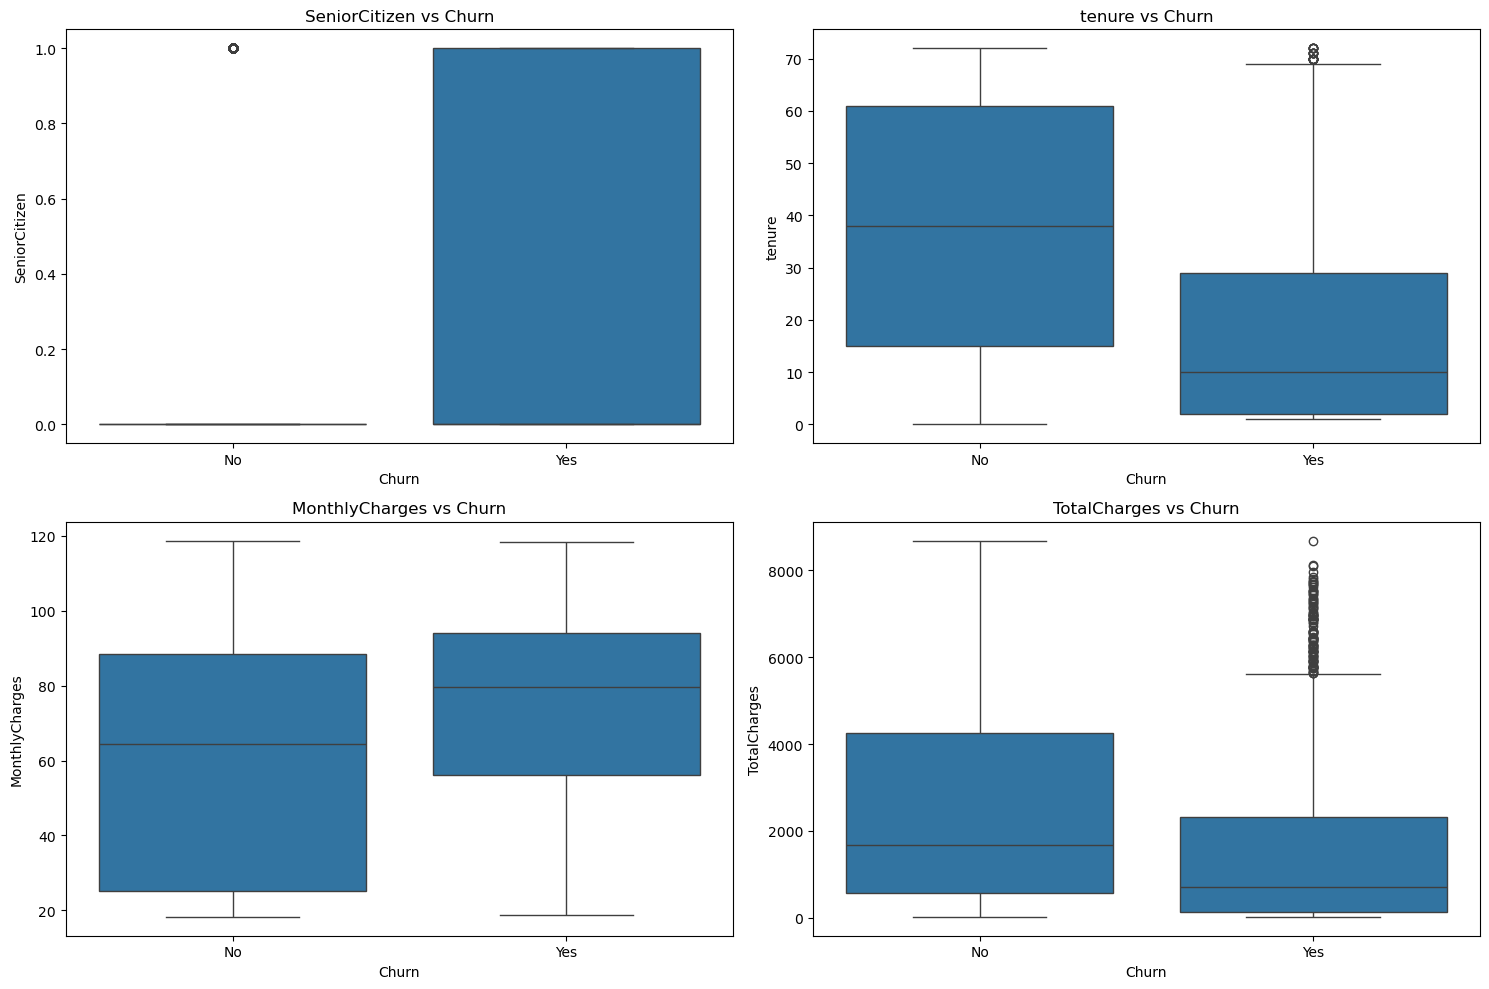

In [9]:
# Analyze numerical variables
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Handle TotalCharges (convert to numeric if it's an object type)
if df['TotalCharges'].dtype == 'object':
    # Replace empty strings with NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    # If TotalCharges is now numeric, add it to numerical columns
    if 'TotalCharges' not in numerical_cols:
        numerical_cols.append('TotalCharges')

# Distribution of numerical features by churn status
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} vs Churn')
plt.tight_layout()
plt.show()

Correlation Analysis

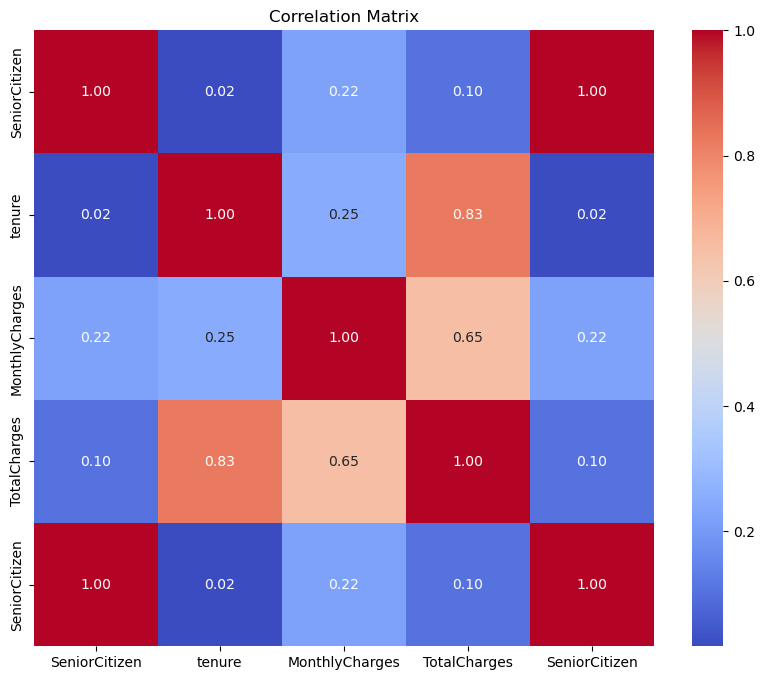

In [10]:
# Create correlation matrix for numerical features
plt.figure(figsize=(10, 8))
corr = df[numerical_cols + ['SeniorCitizen']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Data Preprocessing

In [11]:
def preprocess_data(df):
    # Make a copy of the dataframe
    data = df.copy()
    
    # Check and convert TotalCharges to numeric
    if data['TotalCharges'].dtype == 'object':
        # Replace empty strings with NaN
        data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    
    # Fill missing values
    data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)
    
    # Drop customerID column (not useful for prediction)
    if 'customerID' in data.columns:
        data = data.drop('customerID', axis=1)
    
    # Define features and target
    X = data.drop('Churn', axis=1)
    y = data['Churn'].map({'Yes': 1, 'No': 0})
    
    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    print(f"Categorical features: {categorical_features}")
    print(f"Numerical features: {numerical_features}")
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    return X_train, X_test, y_train, y_test, categorical_features, numerical_features

# Preprocess the data
X_train, X_test, y_train, y_test, categorical_features, numerical_features = preprocess_data(df)

Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


 Build the Machine Learning Pipeline

In [12]:
def build_model(X_train, y_train, categorical_features, numerical_features):
    # Create preprocessor for the pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ])
    
    # Create the pipeline with RandomForest classifier
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    
    # Define hyperparameters for grid search
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    }
    
    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    
    print("Training the model with hyperparameter tuning...")
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best ROC AUC score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Build and train the model
model = build_model(X_train, y_train, categorical_features, numerical_features)

Training the model with hyperparameter tuning...
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best ROC AUC score: 0.8451


Evaluate the Model


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.80      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



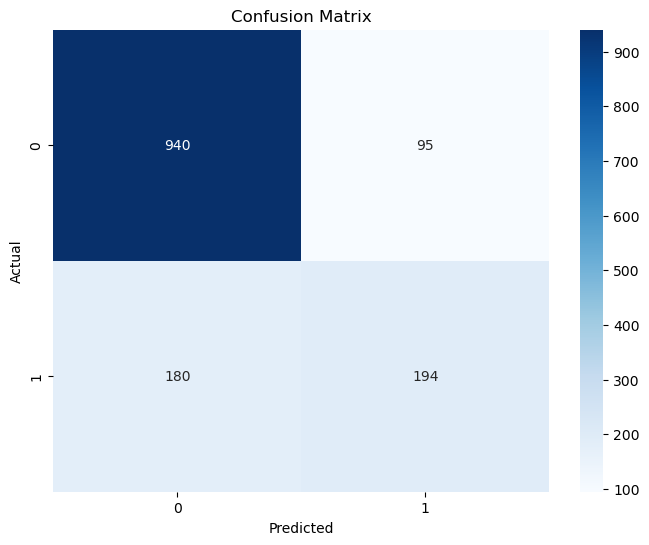

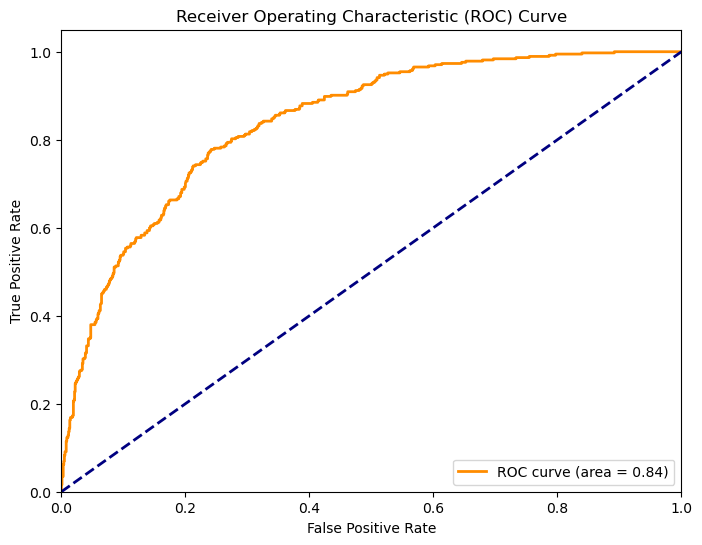

In [13]:
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

# Evaluate the model
roc_auc = evaluate_model(model, X_test, y_test)

Feature Importance Analysis

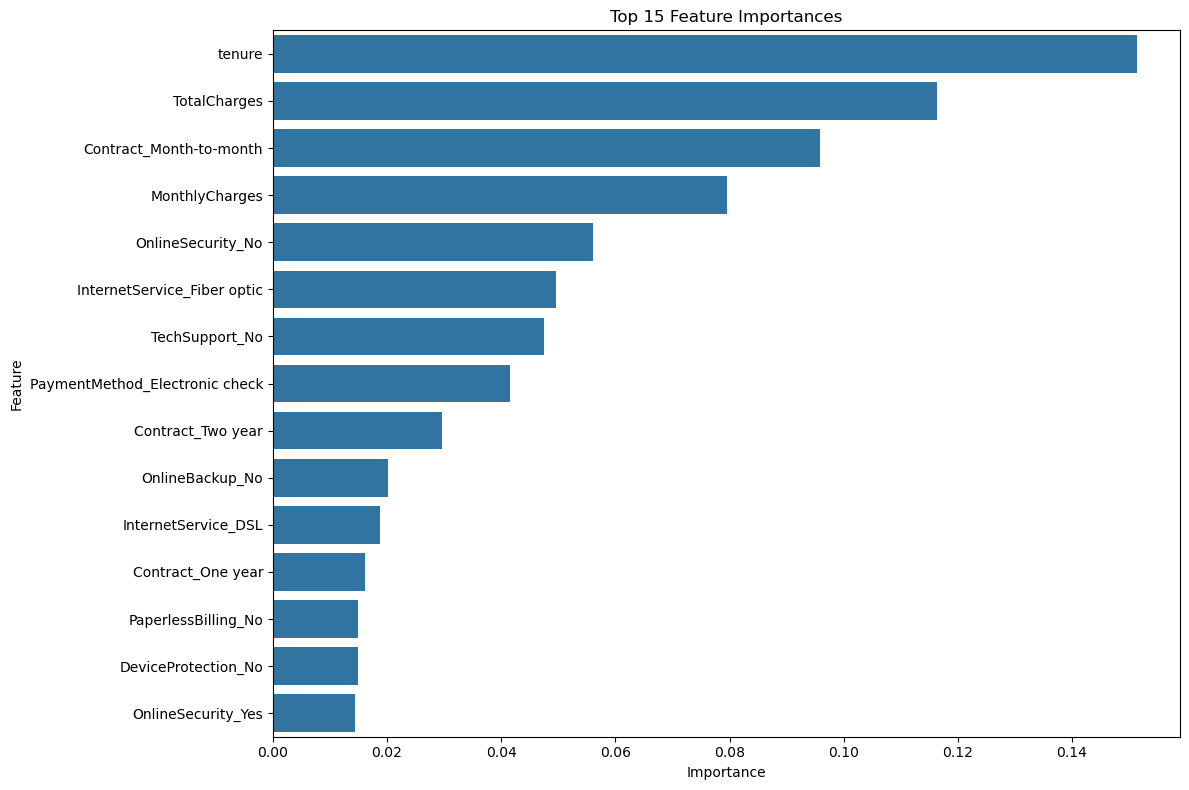


Top 10 most important features:
                           Feature  Importance
1                           tenure    0.151332
3                     TotalCharges    0.116310
36         Contract_Month-to-month    0.095844
2                   MonthlyCharges    0.079583
18               OnlineSecurity_No    0.056064
16     InternetService_Fiber optic    0.049634
27                  TechSupport_No    0.047545
43  PaymentMethod_Electronic check    0.041547
38               Contract_Two year    0.029569
21                 OnlineBackup_No    0.020093


In [14]:
def analyze_feature_importance(model, categorical_features, numerical_features):
    # Get feature names after preprocessing
    ohe = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_features = ohe.get_feature_names_out(categorical_features)
    
    # Combine numerical and one-hot encoded feature names
    feature_names = np.concatenate([numerical_features, cat_features])
    
    # Get feature importances
    importances = model.named_steps['classifier'].feature_importances_
    
    # Create a DataFrame to display feature importances
    feature_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_imp = feature_imp.sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(15))
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()
    
    return feature_imp

# Analyze feature importance
feature_imp = analyze_feature_importance(model, categorical_features, numerical_features)
print("\nTop 10 most important features:")
print(feature_imp.head(10))

Make Predictions on New Data

In [15]:
def predict_churn(model, new_data):
    # Preprocess new data
    if 'customerID' in new_data.columns:
        new_data = new_data.drop('customerID', axis=1)
    
    if 'Churn' in new_data.columns:
        new_data = new_data.drop('Churn', axis=1)
    
    # Make predictions
    predictions = model.predict(new_data)
    probabilities = model.predict_proba(new_data)[:, 1]
    
    # Create results dataframe
    results = new_data.copy()
    results['Churn_Prediction'] = predictions
    results['Churn_Probability'] = probabilities
    results['Churn_Prediction'] = results['Churn_Prediction'].map({1: 'Yes', 0: 'No'})
    
    return results

# Example: Make predictions on a sample of the test data
sample_data = X_test.head(5)
predictions = predict_churn(model, sample_data)
print("\nSample predictions:")
print(predictions[['Churn_Prediction', 'Churn_Probability']])


Sample predictions:
     Churn_Prediction  Churn_Probability
437                No           0.010845
2280              Yes           0.730649
2235               No           0.050732
4460               No           0.334871
3761               No           0.016616


Save the Model

In [16]:
import joblib

# Save the model to a file
joblib.dump(model, 'telco_churn_model.pkl')
print("\nModel saved as 'telco_churn_model.pkl'")


Model saved as 'telco_churn_model.pkl'


Function to Load the Model and Make Predictions

In [17]:
def load_model_and_predict(model_path, new_data_path):
    # Load the model
    loaded_model = joblib.load(model_path)
    
    # Load new data
    new_data = pd.read_csv(new_data_path)
    
    # Make predictions
    results = predict_churn(loaded_model, new_data)
    
    return results

# Example usage (commented out)
# predictions = load_model_and_predict('telco_churn_model.pkl', 'new_customers.csv')
# print(predictions.head())

In [ ]:
a